# Classifier Metropolis Hastings

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

Shows you how to use Metropolis Hastings MCMC for inference problems.

## Poisson

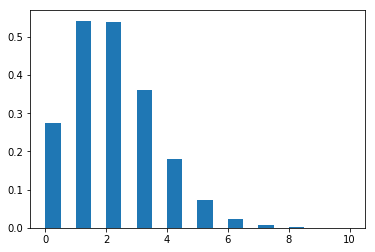

In [2]:
from cag.benchmark.poisson import allocate_observations

# Sample the (true) observations.
theta_true, x_o = allocate_observations(2.)

plt.hist(x_o.numpy(), bins=20, density=True)
plt.show()

In [3]:
from cag.benchmark.poisson import PoissonSimulator as Simulator

simulator = Simulator()

In [4]:
from cag.transition import UniformTransitionDistribution

transition = UniformTransitionDistribution(0,5)

In [129]:
def allocate_classifier():
    hidden = 100
    return torch.nn.Sequential(
    torch.nn.Linear(1, hidden),
    torch.nn.PReLU(),
    torch.nn.Linear(hidden, hidden),
    torch.nn.PReLU(),
    torch.nn.Linear(hidden, hidden),
    torch.nn.PReLU(),
    torch.nn.Linear(hidden, hidden),
    torch.nn.PReLU(),
    torch.nn.Linear(hidden, hidden),
    torch.nn.PReLU(),
    torch.nn.Linear(hidden, hidden),
    torch.nn.PReLU(),
    torch.nn.Linear(hidden, hidden),
    torch.nn.PReLU(),
    torch.nn.Linear(hidden, 1),
    torch.nn.Sigmoid()
)

In [111]:
from cag.inference import ClassifierMetropolisHastings

cmh = ClassifierMetropolisHastings(simulator, allocate_classifier(), transition)

In [112]:
initializer = torch.distributions.uniform.Uniform(0, 5)

#cmh.infer(x_o, initializer, 1000)

tensor([4.3658])
tensor([4.0214])


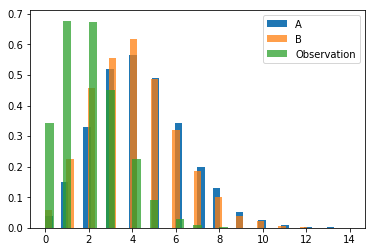

In [88]:
a = initializer.sample().view(-1)
x_a = cmh._simulate(a)
print(a)
b = initializer.sample().view(-1)
x_b = cmh._simulate(b)
print(b)

bins=40
plt.hist(x_a.numpy(), bins=bins, label="A", density=True)
plt.hist(x_b.numpy(), bins=bins, alpha=.75, label="B", density=True)
plt.hist(x_o.numpy(), bins=25, alpha=.75, label="Observation", density=True)
plt.legend()
plt.show()

In [9]:
from cag.util import sample

In [10]:
from cag.inference.avo import r1

4.960824012756348


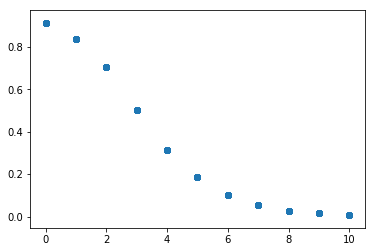

In [132]:
batch_size = 32
real = torch.ones(batch_size, 1)
fake = torch.zeros(batch_size, 1)

bce = torch.nn.BCELoss(reduction="sum")
mse = torch.nn.MSELoss(reduction="sum")
classifier = allocate_classifier()
theta = torch.tensor(b).view(-1, 1)
optimizer = torch.optim.Adam(classifier.parameters())
for i in range(10000):
    x_real = sample(x_o, batch_size)
    x_real.requires_grad = True
    x_fake = sample(x_a, batch_size)
    y_real = classifier(x_real)
    y_fake = classifier(x_fake)
    loss = (mse(y_real, real) + mse(y_fake, fake)) / 2.
    #gradients = torch.autograd.grad(loss, classifier.parameters(), create_graph=True)
    #gradient_norm = 0
    #for gradient in gradients:
    #    gradient_norm = gradient_norm + (gradient ** 2).norm(p=1)
    #gradient_norm /= len(gradients)
    #loss = loss + gradient_norm
    #loss = loss + 10. * r1(y_real, x_real).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
print(loss.item())
y = classifier(x_o)
plt.scatter(x_o.detach().numpy(), y.detach().numpy())
plt.show()

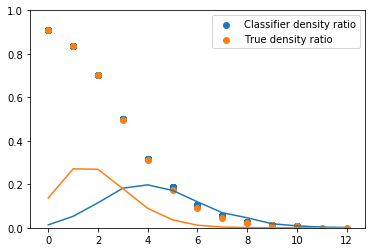

In [133]:
x = np.arange(0, 14, 1)
h_a, _ = np.histogram(x_a.numpy(), density=True, bins=x)
h_o, _ = np.histogram(x_o.numpy(), density=True, bins=x)

x_plot = np.arange(0, 13, 1)
plt.plot(x_plot, h_a)
plt.plot(x_plot, h_o)
plt.scatter(x_o.detach().numpy(), classifier(x_o).detach().numpy(), label="Classifier density ratio")
true_ratio = []
for x in x_plot:
    true_ratio.append(h_o[x] / (h_o[x] + h_a[x]))
plt.scatter(x_plot, true_ratio, label="True density ratio")
plt.legend()
plt.ylim([0, 1])
plt.show()

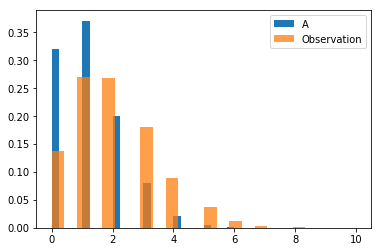

In [13]:
weights = np.ones_like(x_a.numpy()) / (len(x_a.numpy()))
plt.hist(x_a.numpy(), bins=24, label="A", weights=weights)
weights = np.ones_like(x_o.numpy()) / (len(x_o.numpy()))
h = plt.hist(x_o.numpy(), bins=24, alpha=.75, label="Observation", weights=weights)
plt.legend()
plt.show()

0.25002461671829224


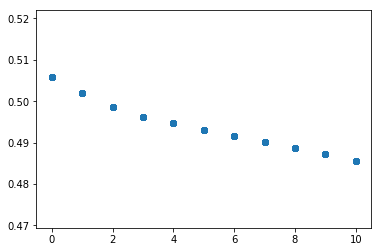

In [14]:
batch_size = 32
real = torch.ones(batch_size, 1)
fake = torch.zeros(batch_size, 1)

bce = torch.nn.BCELoss()
classifier = allocate_classifier()
theta = torch.tensor(b).view(-1, 1)
optimizer = torch.optim.RMSprop(classifier.parameters(), lr=.0001)
for i in range(5000):
    x_real = sample(x_o, batch_size)
    x_real.requires_grad = True
    x_fake = sample(x_b, batch_size)
    #_, x_fake = simulator(T.sample(theta, batch_size))
    #_, x_fake = simulator(transition.sample(theta, batch_size))
    y_real = classifier(x_real)
    y_fake = classifier(x_fake)
    loss = (mse(y_real, real) + mse(y_fake, fake)) / 2.
    gradients = torch.autograd.grad(loss, classifier.parameters(), create_graph=True)
    gradient_norm = 0
    for gradient in gradients:
        gradient_norm = gradient_norm + (gradient ** 2).norm(p=1)
    gradient_norm /= len(gradients)
    loss = loss + gradient_norm
    #loss = loss + 10. * r1(y_real, x_real).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
print(loss.item())
y = classifier(x_o)
plt.scatter(x_o.detach().numpy(), y.detach().numpy())
plt.show()

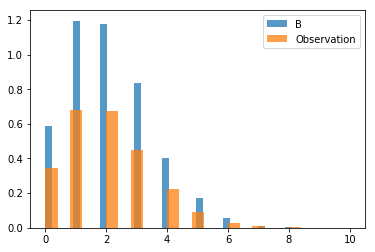

In [15]:
#plt.hist(x_a.numpy(), bins=bins, label="A", density=True)
plt.hist(x_b.numpy(), bins=bins, alpha=.75, label="B", density=True)
plt.hist(x_o.numpy(), bins=25, alpha=.75, label="Observation", density=True)
plt.legend()
plt.show()

## Normal

In [16]:
from torch.distributions.normal import Normal

mu = 0
sigma = 1
normal = Normal(torch.tensor(mu).float(), torch.tensor(sigma).float())
def likelihood(theta):
    return normal.log_prob(theta).exp()

In [17]:
from cag.sampling.transition import UniformTransitionDistribution

min = torch.tensor(-10).float()
max = torch.tensor(10).float()
transition = UniformTransitionDistribution(min, max)

ModuleNotFoundError: No module named 'cag.sampling.transition'

In [ ]:
from cag.sampling import MetropolisHastings

mcmc = MetropolisHastings(likelihood, transition)

In [ ]:
from torch.distributions.uniform import Uniform

initializer = Uniform(min, max)
num_samples = 100000
samples = mcmc.sample(initializer, num_samples).squeeze()

In [ ]:
plt.hist(samples.numpy(), bins=25, density=True, label="Sampled")
x = np.linspace(float(min), float(max), 1000)
plt.plot(x, mlab.normpdf(x, float(mu), float(sigma)), lw=2, c='black', label="Truth")
plt.legend()
plt.show()